# Willian Pacho vs Arthur Theate - PCA Similarity Analysis
## Eintracht Frankfurt - Defensa Central

**Context:**
- Willian Pacho: Frankfurt (23/24) → vendido PSG 40M€ (verano 2024)
- Arthur Theate: Fichado por Frankfurt desde Rennes (verano 2024, 13M€)
- Position: CB (Centre Back)
- Analysis: PCA-based similarity algorithm to validate Theate as Pacho replacement
- **Data analyzed: Season 23/24** (Pacho: Eint Frankfurt, Theate: Rennes)

In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Subir tres niveles desde tfm/teams/frankfurt/ hasta data/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from database.connection import get_db_manager
from tfm.helpers.query_helpers import query_player_pool, add_exogenous_player
from tfm.helpers.algorithms import find_similar_players_cosine

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Build player pool: CB from Big 5 leagues (23/24 season)
big5_leagues = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']

pools = []
for league in big5_leagues:
    try:
        pool = query_player_pool(
            league=league,
            season='2324',
            positions=['CB'],
            max_market_value=25_000_000,
            min_minutes=1400,
            max_age=24,
            additional_filters="AND (transfermarkt_metrics->>'transfermarkt_market_value_eur')::numeric >= 5000000"
        )
        pools.append(pool)
        print(f"{league}: {len(pool)} jugadores")
    except Exception as e:
        print(f"Error en {league}: {e}")

pool_df = pd.concat(pools, ignore_index=True)

print(f"\nPool total: {len(pool_df)} jugadores")
print(f"\nDistribución por liga:")
print(pool_df['league'].value_counts())

2026-01-05 18:14:44,086 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 18:14:44,390 - database.connection - INFO - Database connection successful
2026-01-05 18:14:44,427 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 18:14:44,464 - database.connection - INFO - Database connection successful
2026-01-05 18:14:44,490 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 18:14:44,530 - database.connection - INFO - Database connection successful
2026-01-05 18:14:44,551 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 18:14:44,583 - database.connection - INFO - Database connection successful
2026-01-05 18:14:44,608 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev


ENG-Premier League: 10 jugadores
ESP-La Liga: 13 jugadores
ITA-Serie A: 13 jugadores
GER-Bundesliga: 9 jugadores


2026-01-05 18:14:44,644 - database.connection - INFO - Database connection successful


FRA-Ligue 1: 15 jugadores

Pool total: 60 jugadores

Distribución por liga:
league
FRA-Ligue 1           15
ESP-La Liga           13
ITA-Serie A           13
ENG-Premier League    10
GER-Bundesliga         9
Name: count, dtype: int64


In [3]:
# Add Pacho as exogenous player (target)
full_df = add_exogenous_player(
    pool_df=pool_df,
    player_name='Willian Pacho',
    league='GER-Bundesliga',
    season='2324',
    team='Eint Frankfurt'
)

print(f"DataFrame con Target: {len(full_df)} jugadores")

2026-01-05 18:14:44,696 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 18:14:44,742 - database.connection - INFO - Database connection successful


Added exogenous player: Willian Pacho (Eint Frankfurt, GER-Bundesliga 2324)
Total players in DataFrame: 61
DataFrame con Target: 61 jugadores


In [4]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

fbref_nums = extract_metrics(full_df, 'fbref_metrics')
understat_nums = extract_metrics(full_df, 'understat_metrics')
transfermarkt_nums = extract_metrics(full_df, 'transfermarkt_metrics')

print(f"FBref: {fbref_nums.shape[1]} métricas")
print(f"Understat: {understat_nums.shape[1]} métricas")
print(f"Transfermarkt: {transfermarkt_nums.shape[1]} campos")

FBref: 185 métricas
Understat: 10 métricas
Transfermarkt: 2 campos


In [5]:
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches'
}

fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches FBref: {fbref_per100.shape[1]} columnas")
print(f"Per100touches Understat: {understat_per100.shape[1]} columnas")

Per100touches FBref: 183 columnas
Per100touches Understat: 10 columnas


In [6]:
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    full_df[base_cols],
    fbref_nums,
    understat_nums,
    transfermarkt_nums,
    fbref_per100,
    understat_per100
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} jugadores × {df_final.shape[1]} columnas")

DataFrame final: 61 jugadores × 396 columnas


In [7]:
# Identify target (Pacho) and replacement (Theate)
target = df_final[df_final['player_name'].str.contains('Pacho', case=False, na=False)]
target = target[target['team'].str.contains('Frankfurt', case=False, na=False)]

replacement = df_final[df_final['player_name'].str.contains('Theate', case=False, na=False)]
replacement = replacement[replacement['team'].str.contains('Rennes', case=False, na=False)]

if len(target) == 0:
    raise ValueError("Target no encontrado")
if len(replacement) == 0:
    raise ValueError("Replacement no encontrado")

target_id = target.iloc[0]['unique_player_id']
replacement_id = replacement.iloc[0]['unique_player_id']

print(f"Target: {target.iloc[0]['player_name']} ({target.iloc[0]['team']}, {target.iloc[0]['league']})")
print(f"  ID: {target_id}")
print(f"\nReemplazo: {replacement.iloc[0]['player_name']} ({replacement.iloc[0]['team']}, {replacement.iloc[0]['league']})")
print(f"  ID: {replacement_id}")

Target: Willian Pacho (Eint Frankfurt, GER-Bundesliga)
  ID: 3b6c6d66fee0938d

Reemplazo: Arthur Theate (Rennes, FRA-Ligue 1)
  ID: 4736a05f4cc311c0


In [8]:
# Run PCA similarity algorithm
result = find_similar_players_cosine(
    df=df_final,
    target_player_id=target_id,
    n_similar=30,
    pca_variance=0.85,
    replacement_id=replacement_id,
    robust_scaling=False
)

Target: Willian Pacho (Eint Frankfurt, GER-Bundesliga)
Features: 170 (per 100 touches, excl. GK)
Jugadores: 61 (eliminados 0 con NaNs CORE)
PCA: 20 componentes (varianza: 85.2%)
Reducción: 170 → 20 dimensiones
Top-30 encontrados
Rango similitud: [0.0800, 0.7178]


Visualización generada: /home/jaime/FD/data/tfm/teams/frankfurt/pacho_theate_top10_ranking.png


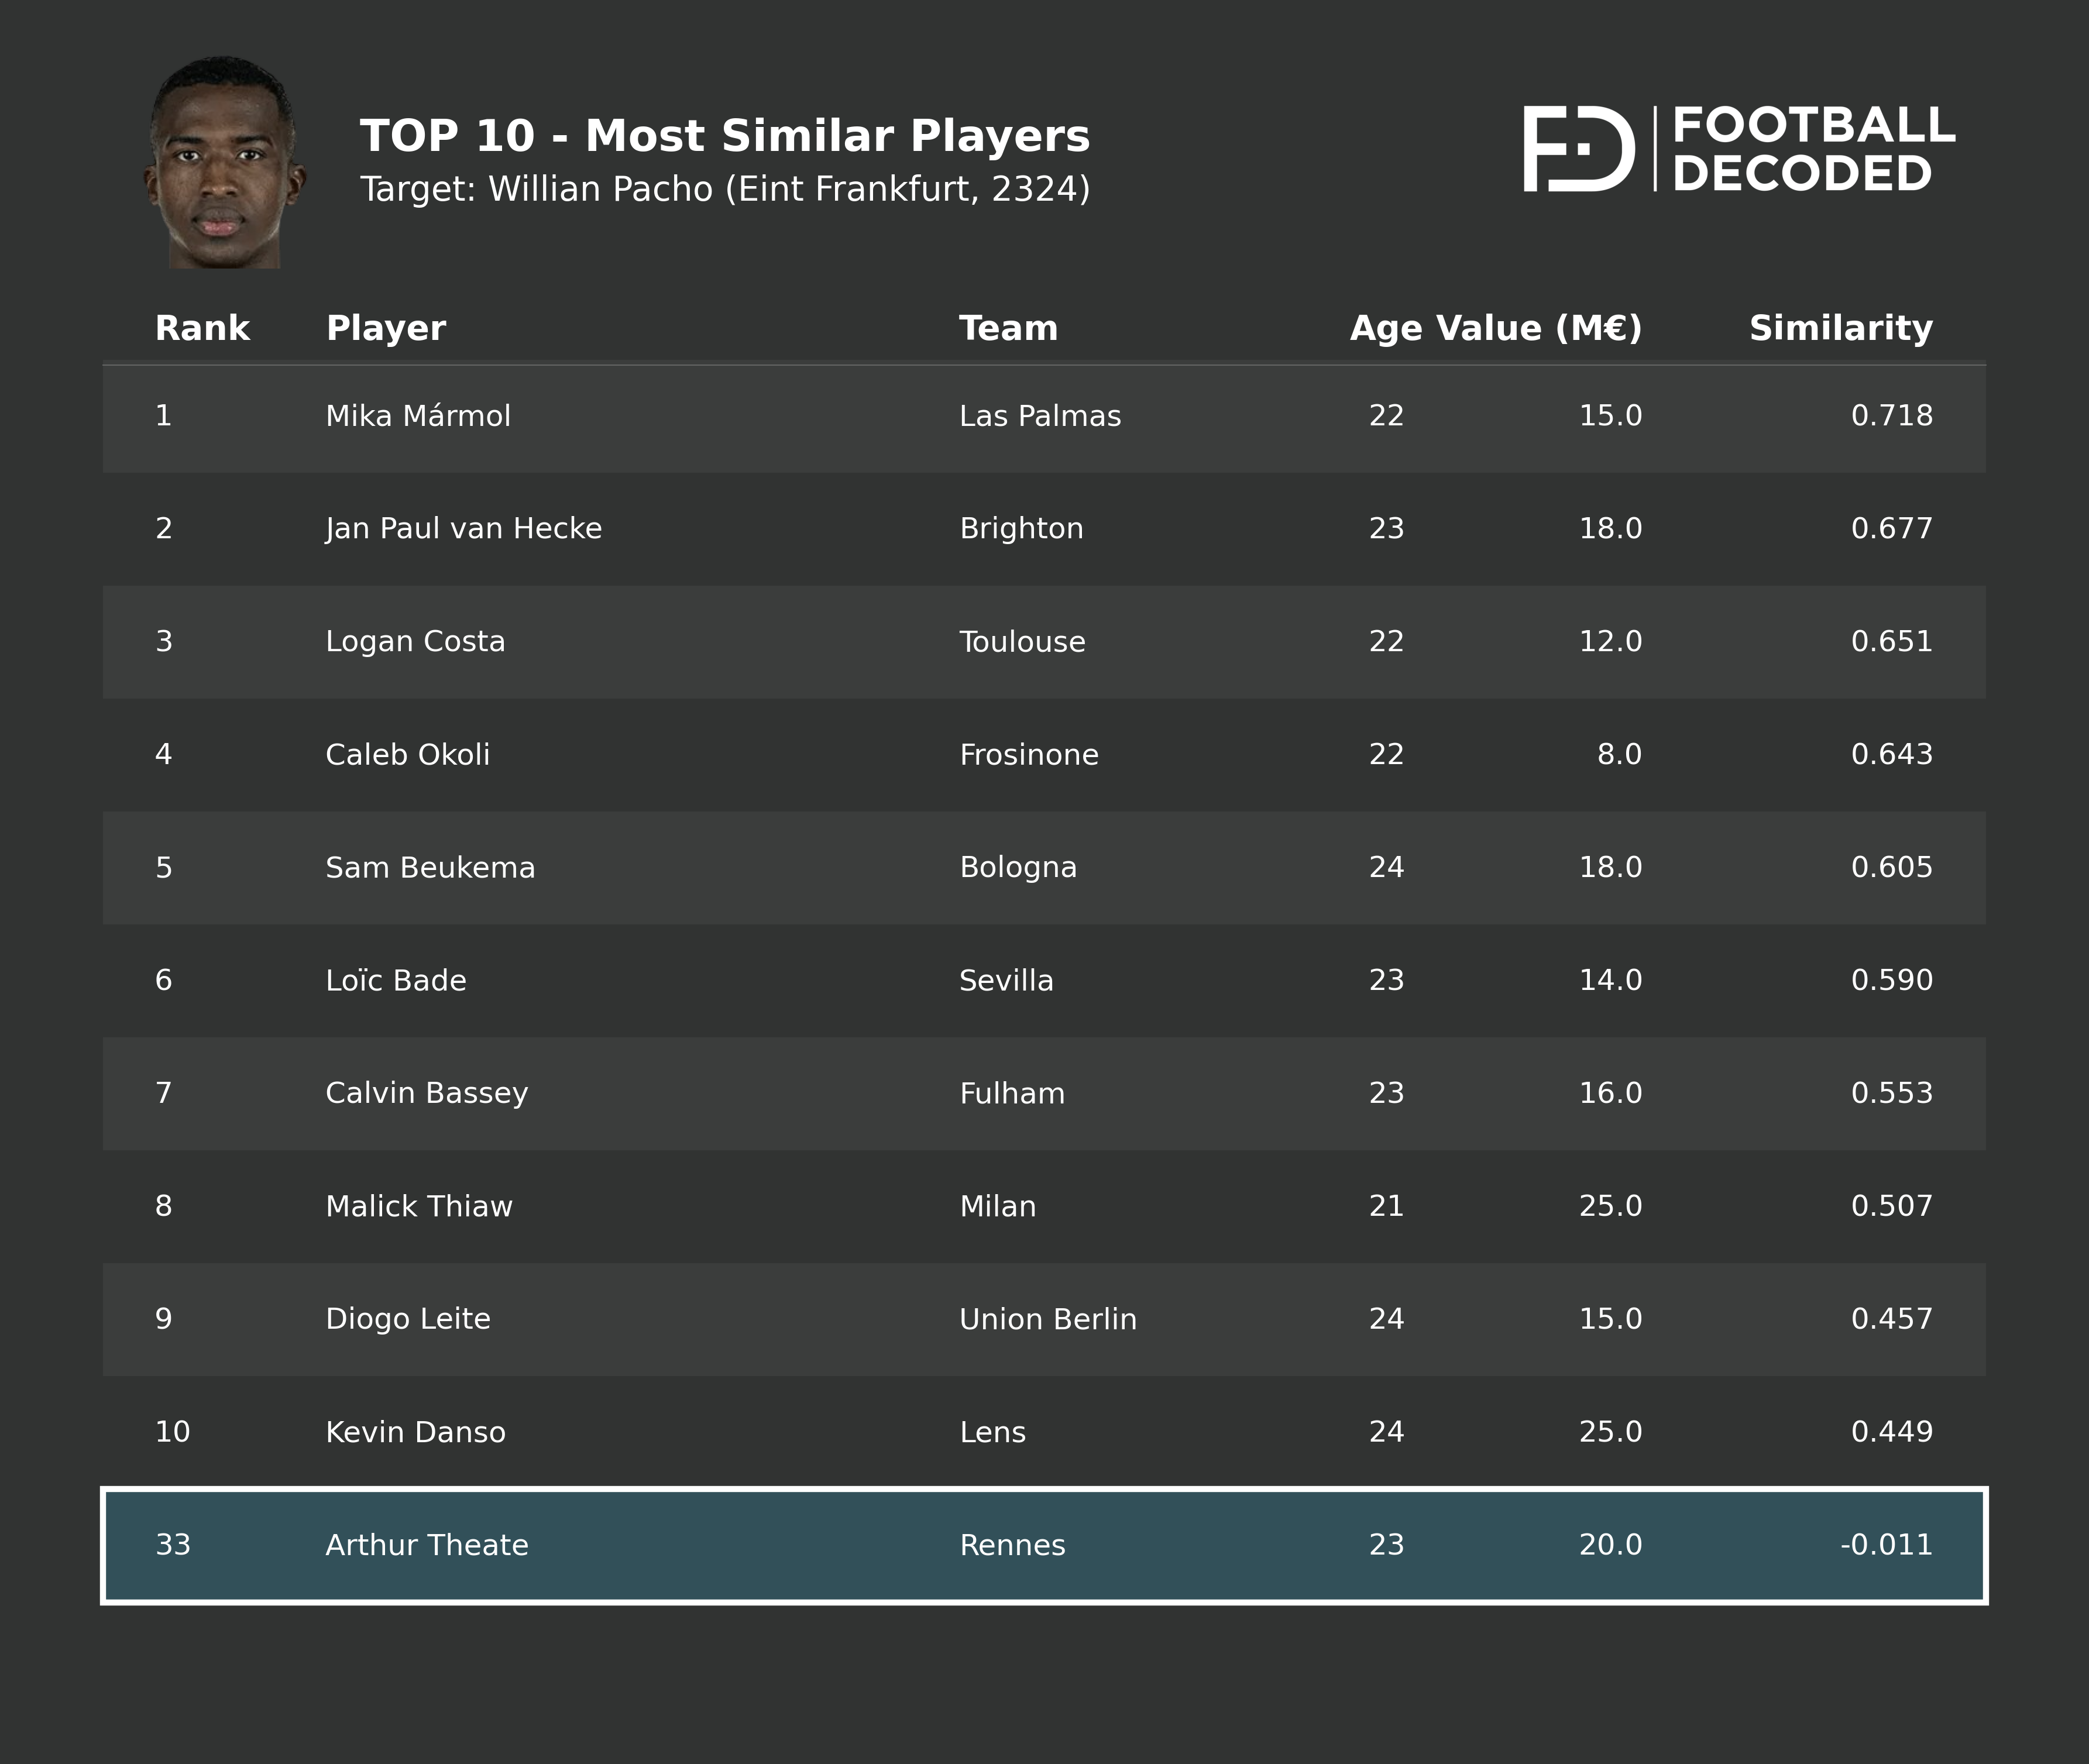

In [9]:
from tfm.helpers.viz_helpers import plot_top10_ranking

output_path = plot_top10_ranking(
    result=result,
    df_data=full_df,
    save_path='pacho_theate_top10_ranking.png',
    target_face_path='/home/jaime/FD/data/blog/caras/tfm/pacho.png',
    highlight_target=True,
    dpi=300
)

print(f"Visualización generada: {output_path}")

from IPython.display import Image, display
display(Image(filename=output_path))

In [10]:
# PCA Information
pca_info = result['pca_info']

print("\nINFORMACIÓN PCA")
print("="*80)
print(f"Dimensiones originales: {pca_info['original_dimensions']}")
print(f"Componentes retenidos: {pca_info['n_components']}")
print(f"Varianza explicada: {pca_info['explained_variance_ratio']:.1%}")
print(f"Ratio de compresión: {pca_info['compression_ratio']:.1%}")
print("\nVarianza por componente (top-5):")
for i, var in enumerate(pca_info['top_5_components_variance'], 1):
    print(f"  PC{i}: {var:.1%}")


INFORMACIÓN PCA
Dimensiones originales: 170
Componentes retenidos: 20
Varianza explicada: 85.2%
Ratio de compresión: 11.8%

Varianza por componente (top-5):
  PC1: 20.1%
  PC2: 13.8%
  PC3: 8.4%
  PC4: 6.9%
  PC5: 5.3%


In [11]:
# Similarity Score Distribution
dist = result['score_distribution']

print("\nDISTRIBUCIÓN DE SIMILITUDES")
print("="*80)
print(f"Mínimo:   {dist['min']:.4f}")
print(f"Q5:       {dist['q5']:.4f}")
print(f"Q25:      {dist['q25']:.4f}")
print(f"Mediana:  {dist['median']:.4f}")
print(f"Q75:      {dist['q75']:.4f}")
print(f"Q95:      {dist['q95']:.4f}")
print(f"Máximo:   {dist['max']:.4f}")
print(f"Media:    {dist['mean']:.4f}")
print(f"Desv.Est: {dist['std']:.4f}")


DISTRIBUCIÓN DE SIMILITUDES
Mínimo:   -0.6006
Q5:       -0.5403
Q25:      -0.2471
Mediana:  0.0564
Q75:      0.3727
Q95:      0.6438
Máximo:   0.7178
Media:    0.0599
Desv.Est: 0.3740
